In [1]:
!pip install --upgrade --force-reinstall cvxpy==1.3.1 numpy==1.24.4 scipy==1.10.1

  Using cached cvxpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.0 MB)
  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Using cached scs-3.2.7.post2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.4 MB)
  Using cached setuptools-79.0.1-py3-none-any.whl (1.3 MB)
  Using cached osqp-1.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (343 kB)
  Using cached ecos-2.0.14-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (218 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (20 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.6.3
    Uninstalling setuptools-65.6.3:
      Successfully uninstalled set

In [2]:
!pip install plotly.express

  Using cached plotly_express-0.4.1-py2.py3-none-any.whl (2.9 kB)
  Using cached plotly-6.0.1-py3-none-any.whl (14.8 MB)
  Using cached narwhals-1.36.0-py3-none-any.whl (331 kB)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import plotly.express as px
import cvxpy as cp
from scipy.stats import multivariate_normal

**Steps for GMM (Regime-Switching)**
- We use log returns from the historical stock prices and put the data into an array with each row as a day's return vector.  
- GMM parameters (# of regimes will be found through grid search). Have to add a small amount of noise to the overall covariance of the data. Prob of each cluster is 1/k where k=number of regimes.  
- E and M steps from HW4 but update it. For each regime, prob that each data point belongs to each regime using multivariate normal PDF. Normalize p_class_given_data for each regime. Update mean, covariance, class prior probabilities.  
- Assign training points to their corresp. regimes (highest posterior prob).  
- Optimize a portfolio for each regime. Maximize expected return - gamma * risk. We don't allow shorting, only long term, so weights >= 0.  
- Assign each test return vector to the closest regime mean.  
- Compute portfolio returns using the corresp. optimized portfolio weights.  
- Compare to our control (equal-weighted) portfolio.

In [4]:
stocks = pd.read_csv('sp500_stocks.csv')
companies = pd.read_csv('sp500_companies.csv')
index = pd.read_csv('sp500_index.csv')

In [5]:
all_symbols = stocks['Symbol'].unique()

In [106]:
# Choosing 50 stocks at random
np.random.seed(35)
selected_symbols = np.random.choice(all_symbols, size=50, replace=False)

In [107]:
selected_stocks = stocks[stocks['Symbol'].isin(selected_symbols)]

In [108]:
print(stocks.columns)

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')


In [109]:
# Prepare portfolio data of our 50 chosen stocks
portfolio = pd.pivot_table(
    selected_stocks,
    index='Date',
    columns='Symbol',
    values='Adj Close'
)

portfolio.dropna(inplace=True)
portfolio.index=pd.to_datetime(portfolio.index)

In [110]:
print(portfolio)

Symbol            AIG         AMD        AMZN         BDX        BIIB  \
Date                                                                    
2015-06-24  50.385323    2.620000   22.042000  121.998207  410.649994   
2015-06-25  49.992939    2.580000   22.004999  122.178993  411.290009   
2015-06-26  50.233173    2.470000   21.905001  122.290985  408.730011   
2015-06-29  49.320278    2.340000   21.493000  122.067116  396.209991   
2015-06-30  49.504459    2.400000   21.704500  121.955162  403.940002   
...               ...         ...         ...         ...         ...   
2024-04-02  78.019997  178.699997  180.690002  241.020004  207.639999   
2024-04-03  77.800003  180.770004  182.410004  243.589996  206.380005   
2024-04-04  76.620003  165.830002  180.000000  243.050003  205.300003   
2024-04-05  77.709999  170.419998  185.070007  246.169998  203.869995   
2024-04-08  77.849998  169.899994  185.190002  241.720001  204.949997   

Symbol             BKNG       BRK-B         CAH   

In [111]:
# This is the generalized version of the code from HW4 (N-dimensional instead of just 2D)
def GMM(dat, k, max_iter=50, tol=1e-4):
    """EM-based Gaussian Mixture Model for N-dimensional data"""
    n_samples, n_features = dat.shape

    # Initialize with n dimensions instead of 2 like in the HW
    covars = np.zeros((k, n_features, n_features)) # covariance matrix
    means = np.zeros((k, n_features)) # mean values
    p_class = np.ones(k) / k # weights/likelihood
    p_data_given_class = np.zeros((n_samples, k)) # P(x_i | cluster = m), or Φ(x_i | μ_m, Σ_m)

    np.random.seed(35)
    # initializations of starting points
    init_idx = np.random.choice(n_samples, size=k, replace=False)
    for i in range(k):
        means[i] = dat[init_idx[i]] # we randomly pick init means from our data points
        covars[i] = np.cov(dat, rowvar=False) + np.eye(n_features) * 1e-6 # added a small amount of noise to global cov

    last_ll = -np.inf

    for step in range(max_iter):
        # Expectation step: responsibilities
        for i in range(k):
            p_data_given_class[:, i] = p_class[i] * multivariate_normal.pdf(dat, mean=means[i], cov=covars[i])
        total_prob = p_data_given_class.sum(axis=1, keepdims=True) # P(x_i)
        p_class_given_data = p_data_given_class / total_prob # responsibility

        # Maximization step: means, covariances, priors
        n = p_class_given_data.sum(axis=0)
        p_class = n / n_samples # update priors for each cluster
        means = np.dot(p_class_given_data.T, dat) / n[:, None]

        for i in range(k):
            diff = dat - means[i]
            weighted_diff = p_class_given_data[:, i][:, None] * diff # responsibility-weighted difference
            covars[i] = np.dot(weighted_diff.T, diff) / n[i] + np.eye(n_features) * 1e-6 # update the covars

        # Check for convergence
        log_likelihood = np.sum(np.log(total_prob))
        if np.abs(log_likelihood - last_ll) < tol:
            break
        last_ll = log_likelihood

    # Choose cluster with highest responsibility
    labels = np.argmax(p_class_given_data, axis=1)

    return labels, p_class_given_data, means, covars, p_class


In [112]:
def run_experiment_custom_gmm(prices, start_idx_train, end_idx_train, start_idx_test, end_idx_test, gamma=10.0, n_regimes=2):
    # Prepare returns
    train_prices = prices.iloc[start_idx_train:end_idx_train]
    test_prices = prices.iloc[start_idx_test:end_idx_test]
    
    # use log returns so we don't have to use the exact same stocks and it's not too skewed
    train_returns = np.log(train_prices / train_prices.shift(1)).dropna()
    test_returns = np.log(test_prices / test_prices.shift(1)).dropna()

    n_assets = train_returns.shape[1]
    m = end_idx_test - start_idx_test
    risk_free_rate = np.log(1.04) * (m / 252)  # risk-free scaled to test window, r = log(1 + annual_rate)*(time/252)

    labels, _, means_, covars_, _ = GMM(train_returns.values, k=n_regimes)

    # Optimize regime weights separately
    regime_weights = {}

    for regime in range(n_regimes):
        regime_data = train_returns.values[labels == regime]
        if regime_data.shape[0] == 0:
            continue # empty regimes get skipped

        mu = regime_data.mean(axis=0)
        cov = np.cov(regime_data.T, bias=True)
        if cov.shape[0] != n_assets or cov.shape[1] != n_assets:
            cov = np.eye(n_assets) * 1e-3
        
        # maximize expected return - gamma * risk
        w = cp.Variable(n_assets)
        objective = cp.Maximize(mu @ w - gamma * cp.quad_form(w, cov))
        constraints = [w >= 0, cp.sum(w) == 1] # w >= 0 because long only
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS)

        if prob.status in ["optimal", "optimal_inaccurate"] and w.value is not None:
            regime_weights[regime] = w.value

    # each day of test set maps to a regime
    test_array = test_returns.values
    test_labels = np.argmin(
        [np.linalg.norm(test_array - mean, axis=1) for mean in means_],
        axis=0
    )

    # apply regime weights to compute returns
    portfolio_returns = np.zeros(len(test_returns))
    portfolio_covs = np.zeros(len(test_returns))

    for regime, weights in regime_weights.items():
        idx = np.where(test_labels == regime)[0]
        regime_returns = test_array[idx]
        portfolio_returns[idx] = np.dot(regime_returns, weights)
        
        cov = np.cov(train_returns.values[labels == regime], rowvar=False) # compute variance
        portfolio_covs[idx] = np.dot(weights.T, np.dot(cov, weights))

    # equal weights
    control_weights = np.ones(n_assets) / n_assets
    control_returns = np.dot(test_returns.values, control_weights)
    
    # metrics scaled to window length instead of annualized
    opt_mean = portfolio_returns.mean() * m
    opt_std = portfolio_returns.std() * np.sqrt(m)
    ctrl_mean = control_returns.mean() * m
    ctrl_std = control_returns.std() * np.sqrt(m)
    ctrl_var = ctrl_std ** 2

    GMM_cov = portfolio_covs.mean()

    opt_sharpe = (opt_mean - risk_free_rate) / math.sqrt(GMM_cov*m)
    ctrl_sharpe = (ctrl_mean - risk_free_rate) / math.sqrt(ctrl_var*m)

    return {
        'GMM Sharpe': opt_sharpe,
        'GMM Return': opt_mean,
        'GMM Volatility': opt_std,
        'GMM Cov': GMM_cov,
        'Control Sharpe': ctrl_sharpe,
        'Control Return': ctrl_mean,
        'Control Volatility': ctrl_std,
        'Control Cov': ctrl_var,
        'GMM Daily Returns': portfolio_returns,
        'Control Daily Returns': control_returns
    }


In [113]:
gammas = [5, 10, 15, 20]
n_regimes_list = [2, 3, 4, 5]

results = []

for gamma in gammas:
    for n_regimes in n_regimes_list:
        try:
            metrics = run_experiment_custom_gmm(portfolio, 0, 400, 400, 600, gamma=gamma, n_regimes=n_regimes)
            results.append({
                'Gamma': gamma,
                'n_regimes': n_regimes,
                'Sharpe': metrics['GMM Sharpe'],
                'Return': metrics['GMM Return'],
                'Volatility': metrics['GMM Volatility'],
                'Cov': metrics['GMM Cov'],
            })
            print(f"Gamma={gamma}, n_regimes={n_regimes} → Sharpe={metrics['GMM Sharpe']:.4f}, Return={metrics['GMM Return']:.4f},  Volatility={metrics['GMM Volatility']:.6f}, Cov={metrics['GMM Cov']:.6f}")
        except Exception as e:
            print(f"Gamma={gamma}, n_regimes={n_regimes} → Failed ({e})")

Gamma=5, n_regimes=2 → Sharpe=3.2510, Return=0.8633,  Volatility=0.118746, Cov=0.000328
Gamma=5, n_regimes=3 → Sharpe=3.6757, Return=0.9093,  Volatility=0.121999, Cov=0.000285
Gamma=5, n_regimes=4 → Sharpe=4.0728, Return=1.1229,  Volatility=0.172384, Cov=0.000359
Gamma=5, n_regimes=5 → Sharpe=3.9949, Return=1.0970,  Volatility=0.171491, Cov=0.000356
Gamma=10, n_regimes=2 → Sharpe=3.3666, Return=0.6384,  Volatility=0.090430, Cov=0.000163
Gamma=10, n_regimes=3 → Sharpe=3.8263, Return=0.6615,  Volatility=0.091085, Cov=0.000136
Gamma=10, n_regimes=4 → Sharpe=4.3626, Return=0.8360,  Volatility=0.127663, Cov=0.000170
Gamma=10, n_regimes=5 → Sharpe=4.2667, Return=0.8223,  Volatility=0.127608, Cov=0.000172
Gamma=15, n_regimes=2 → Sharpe=3.1147, Return=0.4863,  Volatility=0.078377, Cov=0.000107
Gamma=15, n_regimes=3 → Sharpe=3.6331, Return=0.5422,  Volatility=0.086898, Cov=0.000099
Gamma=15, n_regimes=4 → Sharpe=4.5920, Return=0.7479,  Volatility=0.113748, Cov=0.000122
Gamma=15, n_regimes=5 → S

We chose the parameters with the highest sharpe ratio (gamma=20, k=5). We see that the number of regimes being 2, 3, or 4 shows consistently lower sharpe values. If we wanted to maximize returns, we could choose gamma=5 and k=5. A lower gamma means we don't care as much about risk, but the volatility is much higher and the sharpe is much lower. With other random seeds, we get different optimal values, but gamma=20, k=5 is best in this case. 

In [114]:
metrics = run_experiment_custom_gmm(portfolio, 0, 400, 400, 600, gamma=20, n_regimes=4)
for k in list(metrics.keys())[:-2]:
    print(f"{k}: {metrics[k]:.4f}")

GMM Sharpe: 4.5922
GMM Return: 0.6917
GMM Volatility: 0.1090
GMM Cov: 0.0001
Control Sharpe: 0.1301
Control Return: 0.1587
Control Volatility: 0.0694
Control Cov: 0.0048


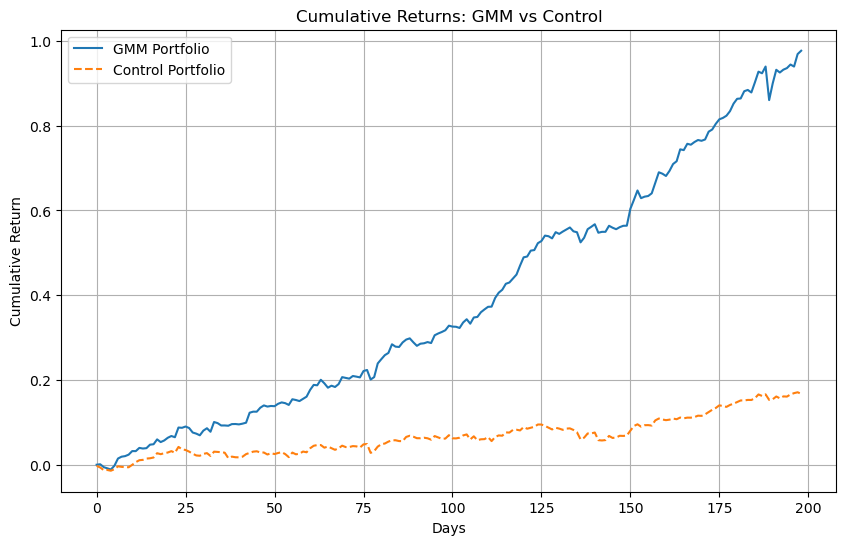

In [115]:
# check to make sure the cumulative returns trend upward consistently instead of a volatile curve

gmm_returns = metrics['GMM Daily Returns']
control_returns = metrics['Control Daily Returns']

gmm_cumulative = np.cumprod(1 + gmm_returns) - 1
control_cumulative = np.cumprod(1 + control_returns) - 1

plt.figure(figsize=(10, 6))
plt.plot(gmm_cumulative, label="GMM Portfolio")
plt.plot(control_cumulative, label="Control Portfolio", linestyle="--")
plt.title("Cumulative Returns: GMM vs Control")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

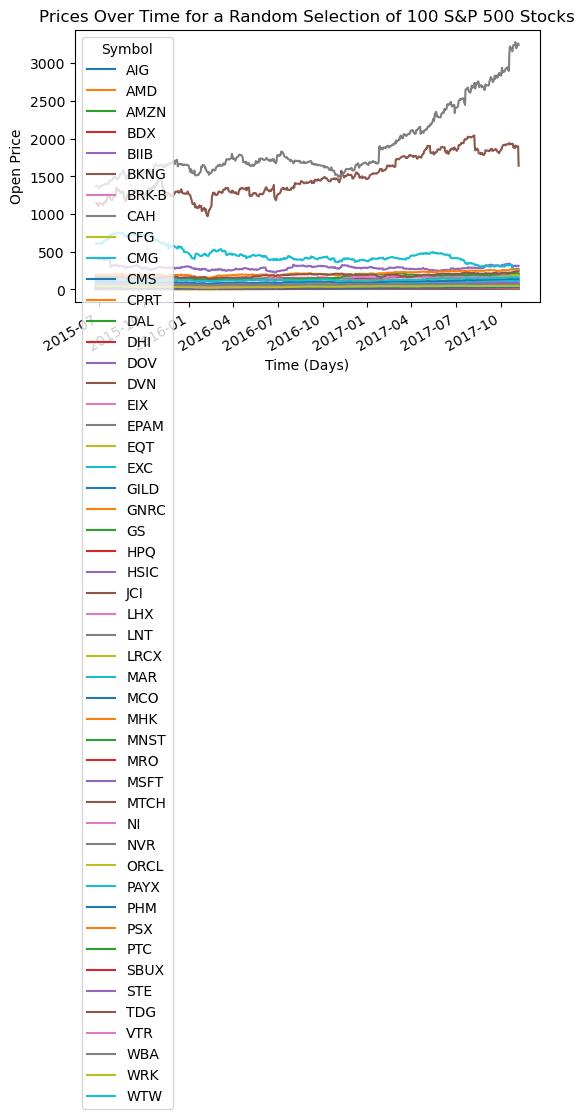

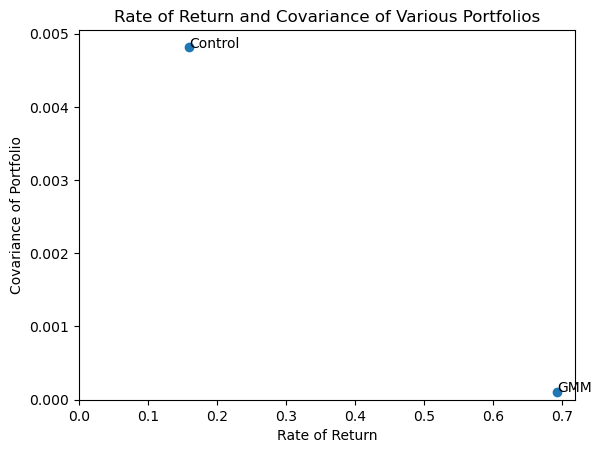

In [116]:
portfolio.iloc[:600].plot(figsize=(6,4))
plt.xlabel("Time (Days)")
plt.ylabel("Open Price")
plt.title("Prices Over Time for a Random Selection of 100 S&P 500 Stocks")

x = [metrics['GMM Return'], metrics['Control Return']]
y = [metrics['GMM Cov'], metrics['Control Cov']]
labels = ["GMM", "Control"]
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.xlabel("Rate of Return")
plt.ylabel("Covariance of Portfolio")
plt.title("Rate of Return and Covariance of Various Portfolios")

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    #ax.set_ylim(top=0.01)
    #ax.set_xlim(right=0.25)
plt.show()